In [1]:
from src.catching import attempt_catch
from src.pokemon import PokemonFactory, Pokemon, StatusEffect
from typing import Tuple, List

import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import seaborn as sns
import pandas as pd
import numpy as np
import json

In [2]:
factory = PokemonFactory()
ball_types = [ "pokeball", "ultraball", "fastball", "heavyball" ]

In [3]:
pokes = factory.create_all(level=100)

In [4]:
avg_per_poke = {}
for ball in ball_types:
    avg_per_poke[ball] = {}
    for poke in pokes:
        count = 0
        tot = 0
        for i in range(1, 1000):
            count += 1
            was_captured, capture_rate = attempt_catch(poke, ball)
            tot += was_captured
        avg_per_poke[ball][poke.name] = tot/count

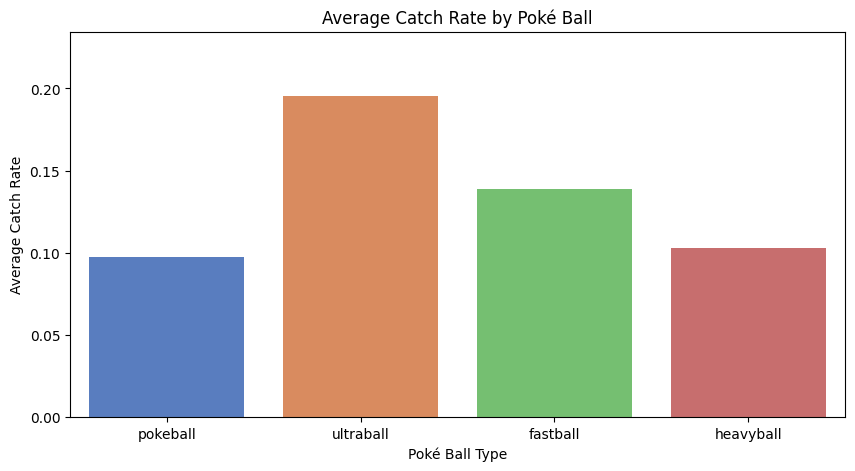

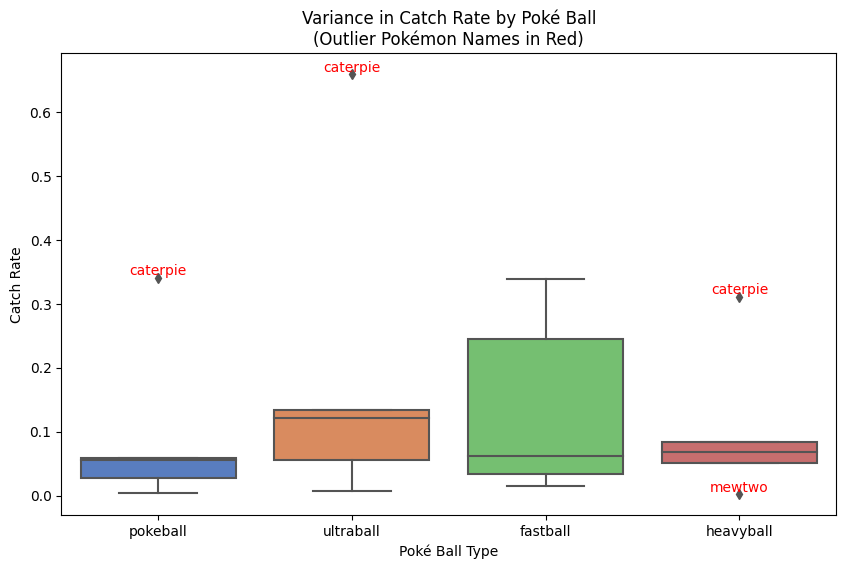

In [5]:
poke_names = []
catch_rates = []
ball_labels = []

for ball, pokes in avg_per_poke.items():
    for poke, rate in pokes.items():
        poke_names.append(poke)
        catch_rates.append(rate)
        ball_labels.append(ball)

# Create a DataFrame for Seaborn
df = pd.DataFrame({'Poké Ball': ball_labels, 'Catch Rate': catch_rates, 'Pokémon': poke_names})

avg_rates = {ball: np.mean(list(avg_per_poke[ball].values())) for ball in ball_types}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(avg_rates.keys()), y=list(avg_rates.values()), palette="muted")
plt.xlabel("Poké Ball Type")
plt.ylabel("Average Catch Rate")
plt.title("Average Catch Rate by Poké Ball")
plt.ylim(0, max(avg_rates.values()) * 1.2)  # Add some padding
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Poké Ball", y="Catch Rate", data=df, palette="muted")

# Identify Outliers
for ball in ball_types:
    ball_data = df[df['Poké Ball'] == ball]['Catch Rate']
    q1 = np.percentile(ball_data, 25)
    q3 = np.percentile(ball_data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df['Poké Ball'] == ball) & ((df['Catch Rate'] < lower_bound) | (df['Catch Rate'] > upper_bound))]

    for _, row in outliers.iterrows():
        plt.text(ball_types.index(ball), row['Catch Rate'], row['Pokémon'], 
                 horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

plt.xlabel("Poké Ball Type")
plt.ylabel("Catch Rate")
plt.title("Variance in Catch Rate by Poké Ball\n(Outlier Pokémon Names in Red)")
plt.show()

### ej_1b

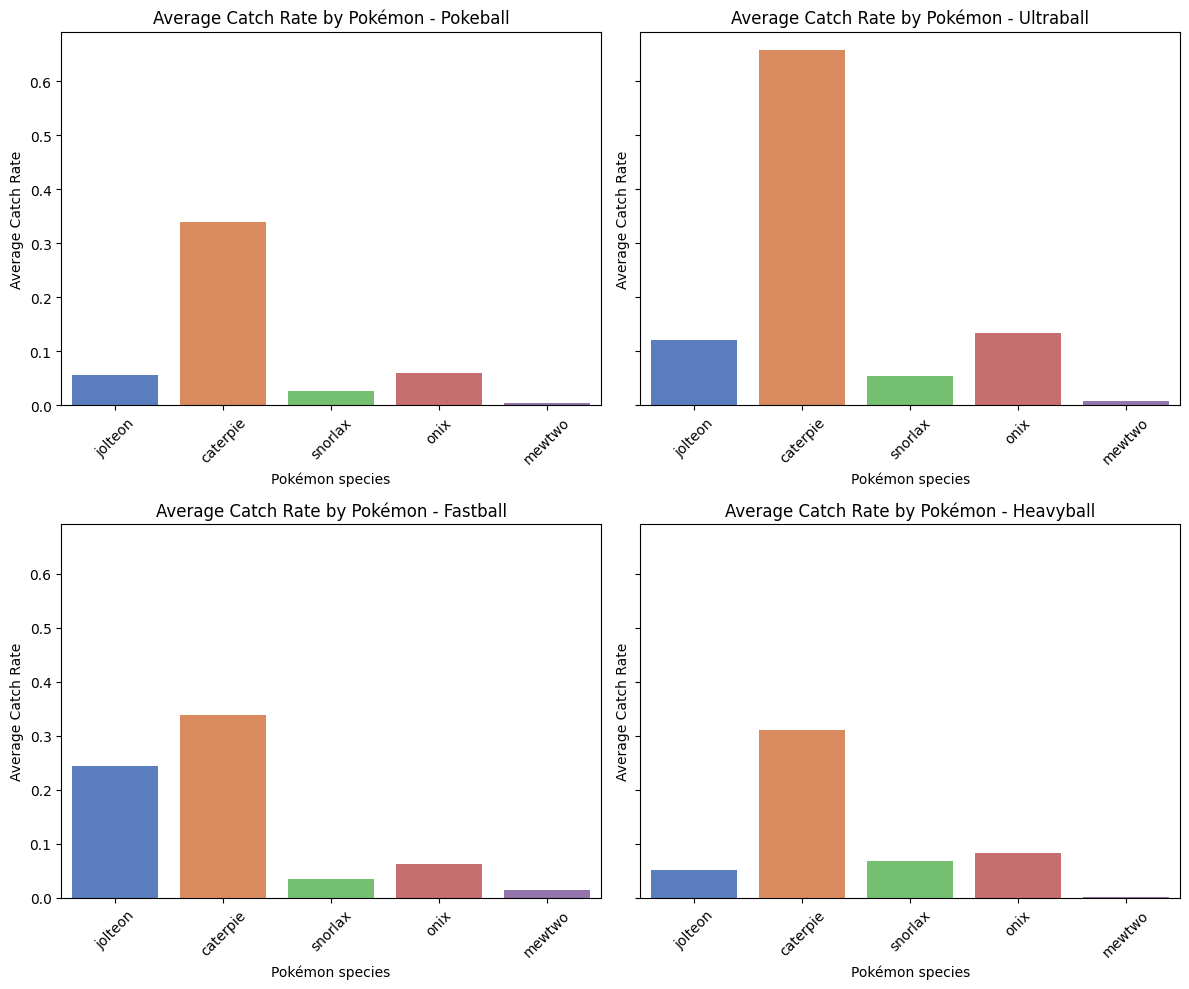

In [6]:
# sharey=True makes them all have the same scale
# the axes are each of the subfigures
_, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for ax, (ball, pokemon) in zip(axes.flat, avg_per_poke.items()):
    sns.barplot(x=list(pokemon.keys()), y=list(pokemon.values()), palette="muted", ax=ax)    
    ax.set_xlabel("Pokémon species")
    ax.set_ylabel("Average Catch Rate")
    ax.set_title(f"Average Catch Rate by Pokémon - {ball.capitalize()}")
    ax.set_xticklabels(pokemon.keys(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

## Ej_2

In [7]:
# Returns a Tuple containing the pokemon and pokeball specified in the single_catch.json file
def get_single_catch_data_from_config() -> Tuple[Pokemon, str]:
    factory = PokemonFactory("pokemon.json")

    with open("configs/single_catch.json", "r") as f:
        config = json.load(f)
    ball = config["pokeball"]
    pokemon = factory.create(config["pokemon"], config["level"], StatusEffect.from_string(config["status"]), config["hp"])    
    return (pokemon, ball)

# Returns a Tuple containing the list of pokemon and pokeball specified in the multiple_catch.json file
def get_multiple_catch_data_from_config() -> Tuple[List[Pokemon], str]:
    factory = PokemonFactory("pokemon.json")

    with open("configs/multiple_catch.json", "r") as f:
        config = json.load(f)
    ball = config["pokeball"]
    pokemon_list = factory.create_many(config["pokemon"], config["level"], StatusEffect.from_string(config["status"]), config["hp"])    
    return (pokemon_list, ball)

### Ej_2a

In [8]:
poke, ball = get_single_catch_data_from_config()
effect_vs_catch_rate = {}
for effect in sorted(list(StatusEffect), key=lambda x: x.modifier):
    poke.set_status_effect(effect)
    effect_vs_catch_rate[effect.status_name.lower().capitalize()] = attempt_catch(poke, ball)[1]

print(effect_vs_catch_rate)

{'None': 0.2344, 'Poison': 0.3516, 'Burn': 0.3516, 'Paralysis': 0.3516, 'Sleep': 0.4688, 'Freeze': 0.4688}


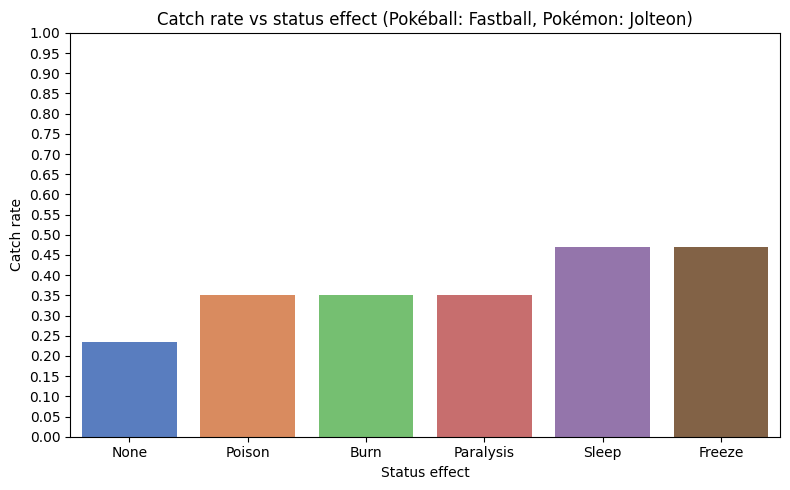

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(effect_vs_catch_rate.keys()), y=list(effect_vs_catch_rate.values()), palette="muted")
plt.xlabel("Status effect")
plt.ylabel("Catch rate")
plt.title(f"Catch rate vs status effect (Pokéball: {ball.capitalize()}, Pokémon: {poke.name.capitalize()})")

yticks = np.arange(0, 1.05, 0.05)
plt.yticks(yticks)

plt.tight_layout()
plt.show()


### Ej_2b

In [10]:
hp_perc_vs_catch_rate = {}
hp_perc_vs_catch_rate_with_noise = {}

pokes, ball = get_multiple_catch_data_from_config()

for poke in pokes:
    hp_perc_vs_catch_rate[poke.name] = {}
    hp_perc_vs_catch_rate_with_noise[poke.name] = {}

    hp_perc = round((poke.current_hp* 100)/poke.max_hp)
    while poke.current_hp > 0.01:
        hp_perc_vs_catch_rate[poke.name][hp_perc] = attempt_catch(poke, ball)[1]
        hp_perc_vs_catch_rate_with_noise[poke.name][hp_perc] = attempt_catch(poke, ball, 0.15)[1]
        hp_perc -= 1
        poke.damage(0.01)


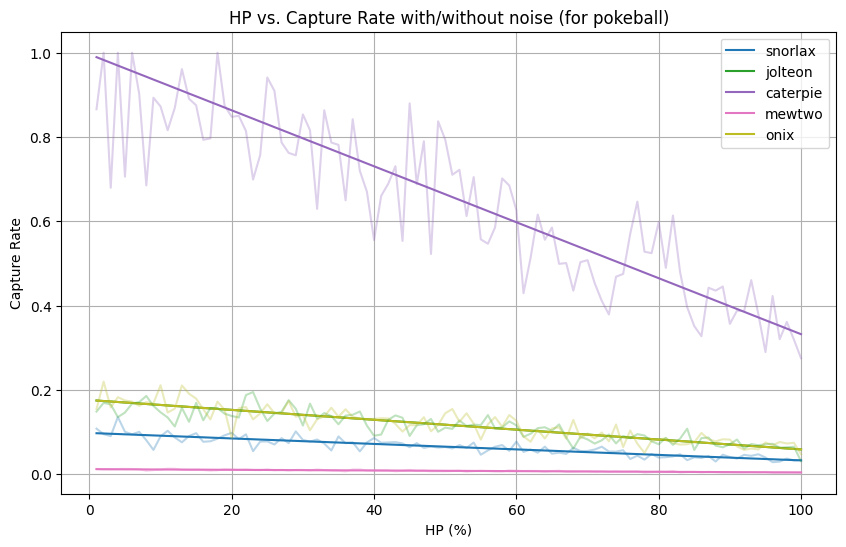

In [11]:
plt.figure(figsize=(10, 6))

colors = plt.get_cmap("tab10")

for i, (poke, rates) in enumerate(hp_perc_vs_catch_rate.items()):
    hp_values = list(rates.keys())
    capture_probs = list(rates.values())
    
    plt.plot(hp_values, capture_probs, linestyle="-", color=colors(i / len(hp_perc_vs_catch_rate)), label=f"{poke}")

for i, (poke, rates) in enumerate(hp_perc_vs_catch_rate_with_noise.items()):
    hp_values = list(rates.keys())
    capture_probs = list(rates.values())
    
    plt.plot(hp_values, capture_probs, linestyle="-", color=colors(i / len(hp_perc_vs_catch_rate_with_noise)), alpha=0.3)

plt.xlabel("HP (%)")
plt.ylabel("Capture Rate")
plt.title(f"HP vs. Capture Rate with/without noise (for {ball})")
plt.legend()
plt.grid()
plt.show()

**Nota**: Se aclara que los gráficos de líneas rectas son sin ruido y los gráficos dispersos que la acompañan son para el caso de con ruido

### Ej_2c

> Para este asumo que hay que mencionar las propiedades que se trataron en los ejs 2.a y 2.b, pues en el enunciado no se pide nada respecto a pokeball 
> (y lo hace recién en el 2.d), también se podría mencionar como cada pokémon parece tener una probabilidad intríncica diferente (ej mewtwo vs caterpie) > y poner gráficos para comparar dos pokés en condiciones ideales y con una pokéball o ultraball que no se ve afectada por sus propiedades inmutables
> (como se vio en el Ej_1b) ~ Berni 

### Ej_2d

> Para este calculo que hay que buscar las mejores configuraciones de uno, dos o tres pokémon para atraparlos y comprar sus catch rates en un
> gráfico, SIN CONTAR el nivel pues este se pide explícitamente en el Ej_2e. Also yo no pondría a caterpie, se puede llegar a su mejor
> catch rate (100% de captura) sin estar en la mejor configuración ~ Berni

### Ej_2e

> Idem al anterior, pero ahora teniendo en cuenta el nivel